v2

# 1. Preparing the environment

## Installing modules and importing libraries

In [1]:
!pip install nxviz
!pip install netwulf

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import unicodedata
import re
import matplotlib.pyplot as plt
import nxviz as nv
import seaborn as sns
from nxviz import annotate, highlights
import netwulf
from netwulf import tools

/usr/local/lib/python3.10/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


# 2. Data treatment

## Exporting the original dataset with all data available

In [3]:
# prompt: use o pandas para criar um dataframe lendo o csv DADOS_ABERTOS_MEDICAMENTOS.csv com codificação latin

import pandas as pd

# Meds is the complete Dataframe

meds = pd.read_csv('/content/drive/MyDrive/Matérias/AED-II/U1T3/DADOS_ABERTOS_MEDICAMENTOS.csv', encoding='latin-1', sep=';')
#meds

## Filtering the dataframe by first normalizing the columns informations and then removing null/missing values.

In [4]:
# prompt: use o dataframe meds e filtre os dados para remover todas as linhas que possuem a coluna PRINCIPIO_ATIVO igual a NaN

# The function normalize_text is used to normalize the characters on the table/dataframe to avoid execution errors
# while manipulating data

def normalize_text(text):
  # Convert the input to string before normalizing
  text = str(text)
  text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
  return text.upper()


# Before using the data it is neccessary to filter the data to avoid data block that contains missing properties or values
# So first the column PRINCIPIO_ATIVO - which stands for the medicine's active ingredient(s) - and the name of the
# product will be normalized to upper case
meds['PRINCIPIO_ATIVO'] = meds['PRINCIPIO_ATIVO'].apply(normalize_text)
meds['NOME-PRODUTO'] = meds['NOME_PRODUTO'].apply(normalize_text)
meds['CATEGORIA_REGULATORIA'] = meds['CATEGORIA_REGULATORIA'].apply(normalize_text)

# The next line removes the individuals whose active ingredients are NaN/NAN ( missing value )
meds_cleaned = meds[meds['PRINCIPIO_ATIVO'] != 'NAN']
meds_cleaned = meds[meds['CATEGORIA_REGULATORIA'] != 'nan']
meds_cleaned = meds[meds['CATEGORIA_REGULATORIA'] != 'PRODUTO DE T']
meds_cleaned = meds[pd.notnull(meds['CATEGORIA_REGULATORIA'])]

# ou meds_cleaned = meds[~pd.isnull(meds['CATEGORIA_REGULATORIA'])]
meds_cleaned = meds[meds['SITUACAO_REGISTRO'] != 'CADUCO/CANCELADO']

# Because of hardware and processing limitations the datafram analysed can be reduced to only 6000 rows from the almost 12k
meds_half = meds_cleaned.head(6000)
#meds_half

In [5]:
## Verifying if there is any NaN value on the columns that will be used to analyse dataframe.

print(meds_cleaned['SITUACAO_REGISTRO'].unique(),"\n")
print(meds_cleaned['PRINCIPIO_ATIVO'].unique(),"\n")
print(meds_cleaned['NOME_PRODUTO'].unique(),"\n")
print(meds_cleaned['CATEGORIA_REGULATORIA'].unique(),"\n")

print(type((meds_cleaned['CATEGORIA_REGULATORIA'].unique())[5]))
print((meds_cleaned['CATEGORIA_REGULATORIA'].unique())[5])

unique_category = meds_cleaned['CATEGORIA_REGULATORIA'].unique()

# Removing nan value from the categories in CATEGORIA_REGULATORIA
## unique_category receives all the available values from CATEGORIA_REGULATORIA
unique_category = [x for x in unique_category if not (isinstance(x, float) and np.isnan(x))]
unique_category = [x for x in unique_category if x != 'NAN' and x != 'PRODUTO DE T']

## Re-shaping the datafram meds_cleaned with only the lines from column CATEGORIA_REGULATORIA with valid values from unique_category
meds_cleaned = meds_cleaned[meds_cleaned['CATEGORIA_REGULATORIA'].isin(unique_category)]

# Checking if nan value was removed
print(meds_cleaned['CATEGORIA_REGULATORIA'].unique(),"\n")

['VÁLIDO' 'ATIVO'] 

['EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA +  EXTRATO FLUIDO DE PASSIFLORA ALATA +  SALICILATO DE SODIO +  TINTURA AGONIADA PLUMERIA'
 'ACIDO ACETILSALICILICO' 'ACETATO DE ABIRATERONA' ...
 'DIPIRONA MONOIDRATADA +  CAFEINA ANIDRA +  CITRATO DE ORFENADRINA'
 'CLORIDRATO DE SITAGLIPTINA MONOIDRATADO'
 'CLORETO DE SODIO +  CLORETO DE POTASSIO +  CLORETO DE CALCIO DIIDRATADO +  LACTATO DE SODIO'] 

['A SAÚDE DA MULHER' 'AAS' 'AAS PROTECT' ... 'TEDHOL' 'VYCRIS' 'ZULIC'] 

['NOVO' 'SIMILAR' 'FITOTERAPICO' 'ESPECIFICO' 'GENERICO' 'NAN' 'BIOLOGICO'
 'DINAMIZADO' 'RADIOFARMACO' 'PRODUTO DE T'] 

<class 'str'>
NAN
['NOVO' 'SIMILAR' 'FITOTERAPICO' 'ESPECIFICO' 'GENERICO' 'BIOLOGICO'
 'DINAMIZADO' 'RADIOFARMACO'] 



## Creating new datasets from the filtred main dataframe

In [6]:
meds_cleaned.to_csv('Medicines_Filtered.csv', index=False)
meds_half.to_csv('Medicines_Half.csv', index=False)

medicines = pd.read_csv('Medicines_Filtered.csv')
medicines_half = pd.read_csv('Medicines_Half.csv')

# 3. First Network - Creating Graph G with medicines as nodes and similar active ingredients as edges

### Getting the active ingredients from PRINCIPIO_ATIVO column and creating an array without duplicates

> Important: If the dataframe used is the one with half the data use the line with medicines_half

In [7]:
# The array active_array is created to have all the row values from the PRINCIPIO_ATIVO column ( Active ingredient )

#active_array = medicines_half['PRINCIPIO_ATIVO'].unique()
active_array = medicines['PRINCIPIO_ATIVO'].unique()
active_array

array(['EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA +  EXTRATO FLUIDO DE PASSIFLORA ALATA +  SALICILATO DE SODIO +  TINTURA AGONIADA PLUMERIA',
       'ACIDO ACETILSALICILICO', 'ACETATO DE ABIRATERONA', ...,
       'DIPIRONA MONOIDRATADA +  CAFEINA ANIDRA +  CITRATO DE ORFENADRINA',
       'CLORIDRATO DE SITAGLIPTINA MONOIDRATADO',
       'CLORETO DE SODIO +  CLORETO DE POTASSIO +  CLORETO DE CALCIO DIIDRATADO +  LACTATO DE SODIO'],
      dtype=object)

In [8]:
# The active_array is treated as to split the multiple ingredients from medicines that have more
# than one active ingredients. The active ingredients are separeted by '+' symbol when there are more than one.

new_active_array = []
for active in active_array:
  new_active_array.extend(active.split('+'))

print("new_active_array:", new_active_array)

new_active_array = [active.strip() for active in new_active_array]
print("new_active_arary strip:", new_active_array)
print("new_active_arary stripped lenght:", len(new_active_array))

try:
  indice = new_active_array.index("EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA")
  print(f"The element '{'EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA'}' was found at index {indice}.")
except ValueError:
  print(f"The element '{'EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA'}' was not found in array.")


active_filtered = [active for active in new_active_array if active]
print("new_active_arary active:", active_filtered)
print("new_active_arary active lenght:", len(active_filtered))

active_filtered = list(set(active_filtered))

print("active_filtered listed:", active_filtered)
print("active_filtered listed lenght:", len(active_filtered))


try:
  indice = active_filtered.index("EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA")
  print(f"The element '{'EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA'}' was found at index {indice}.")
except ValueError:
  print(f"The element '{'EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA'}' was not found in array.")


new_active_array: ['EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA ', '  EXTRATO FLUIDO DE PASSIFLORA ALATA ', '  SALICILATO DE SODIO ', '  TINTURA AGONIADA PLUMERIA', 'ACIDO ACETILSALICILICO', 'ACETATO DE ABIRATERONA', 'CLOTRIMAZOL', 'BETAINA ', '  CITRATO DE COLINA ', '  DL-METIONINA ', '  LEVOMETIONINA', 'DIPIRONA', 'ATENOLOL', 'ATENOLOL ', '  CLORTALIDONA', 'CLORIDRATO DE DULOXETINA', 'HEDERA HELIX L.', 'CRATAEGUS RHIPIDOPHYLLA GAND. ', '  PASSIFLORA INCARNATA L. ', '  VALERIANA OFFICINALIS L.', 'ACETATO DE RACEALFATOCOFEROL ', '  BETACAROTENO ', '  OXIDO CUPRICO ', '  RIBOFLAVINA ', '  SELENATO DE SODIO ', '  ACIDO ASCORBICO ', '  OXIDO CUPRICO ', '  OXIDO DE ZINCO', 'ACEBROFILINA', 'ACECLOFENACO', 'PEROXIDO DE UREIA', 'INDAPAMIDA ', '  PERINDOPRIL ARGININA', 'BESILATO DE ANLODIPINO ', '  PERINDOPRIL ARGININA', 'PERINDOPRIL ARGININA', 'CLORIDRATO DE TIAMINA', 'ACETATO DE CIPROTERONA', 'ACETATO DE CIPROTERONA ', '  ETINILESTRADIOL', 'ACETATO DE CLORMADINONA ', '  ETINILESTRADIOL', 'ACET

In [9]:
new_active_array_original = active_filtered.copy() # Create a copy of the original array with the active ingredients supposedly without duplicates.

elemento_procurado = 'ACETATO DE CIPROTERONA'  # Define the element you want to search
ocorrencias = 0
indice_atual = 0

while True:
    try:
        # Look out for the first occurrence
        indice = new_active_array_original.index(elemento_procurado, indice_atual)
        ocorrencias += 1
        print(f"The element '{elemento_procurado}' appears in index {indice}. Occurrence: {ocorrencias}")
        indice_atual = indice + 1  # Update initial index for the next search
    except ValueError:
        # If ValueError is thrown, there is no more occurrences
        break

if ocorrencias > 1:
    print(f"The element '{elemento_procurado}' appears more than once on the array.")
else:
    print(f"The element '{elemento_procurado}' appears only once ( or none ) on the array.")

# Agora você pode transformar o array para excluir as duplicatas
# new_active_array = list(set(new_active_array))

The element 'ACETATO DE CIPROTERONA' appears in index 764. Occurrence: 1
The element 'ACETATO DE CIPROTERONA' appears only once ( or none ) on the array.


### Creating a co-occurrence network of active ingredients between medicines

In [10]:
import networkx as nx

# Criando um grafo não direcionado
G = nx.Graph()

for index, medicine in medicines.iterrows():

  name_product = medicine['NOME_PRODUTO']

  type_product = medicine['TIPO_PRODUTO']
  category = medicine['CATEGORIA_REGULATORIA']
  classification = medicine['CLASSE_TERAPEUTICA']
  company = medicine['EMPRESA_DETENTORA_REGISTRO']

  node_attributes = {
      'type': type_product,
      'category': category,
      'classification': classification,
      'company': company
  }

  #print(type_product, name_product, category, classification, company)

  G.add_node(name_product, **node_attributes)

#print(list(G.nodes()))

# Adicionando os nós ao grafo com base na coluna TIPO_PRODUTO
#for nome_produto in meds_cleaned['NOME_PRODUTO'].unique():
#  G.add_node(nome_produto)

# Mostrar todos os nós do grafo
#print(list(G.nodes()))


In [11]:
## Filtering products/medicines by active ingredient

import random

active_ingredients = list(set(active_filtered))
color_mapping = {active_ingredient: i for i, active_ingredient in enumerate(active_ingredients)}

for active in active_filtered:

    #print("Active:", active)

    #filtered_products = medicines_half[medicines_half['PRINCIPIO_ATIVO'].str.contains(re.escape(active), na=False)]['NOME_PRODUTO'].unique()

    filtered_products = medicines[medicines['PRINCIPIO_ATIVO'].str.contains(re.escape(active), na=False)]['NOME_PRODUTO'].unique()

    #print("Filtered products:", filtered_products)
    #print(len(filtered_products))

    for i in range(len(filtered_products)):
      for j in range (i+1, len(filtered_products)):
        if filtered_products[i] != filtered_products[j]:

          color_index = color_mapping[active]

          G.add_edge(filtered_products[i] , filtered_products[j], color=color_index)


In [12]:
#pos = nx.circular_layout(G)
#plt.figure(figsize=(12, 12))

#nx.draw(G, pos, with_labels=False, node_size=10)
#plt.show()

### Plotting the Degree Correlation of the Global Graph

{'A SAÚDE DA MULHER': 94, 'AAS': 93, 'AAS PROTECT': 93, 'ABBA': 10, 'ABC': 16, 'ABCLER ABNAT': 15, 'ABERALGINA': 116, 'ABLOK': 23, 'ABLOK PLUS': 28, 'ABRETIA': 18, 'ABRIFIT': 32, 'ABRILAR': 32, 'ACALMILFITO': 526, 'ACCUVIT': 163, 'ACEBROFILINA': 13, 'ACECLOFENACO': 8, 'ACEFLOR': 8, 'ACERATUM': 10, 'ACERTALIX': 42, 'ACERTANLO': 87, 'ACERTIL': 34, 'ACESYL': 85, 'ACETATO DE ABIRATERONA': 10, 'ACETATO DE CIPROTERONA + ETINILESTRADIOL': 20, 'ACETATO DE CIPROTERONA+ETINILESTRADIOL': 173, 'ACETATO DE CLORMADINONA + ETINILESTRADIOL': 170, 'ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA': 479, 'ACETATO DE DEXAMETASONA': 72, 'ACETATO DE HIDROCORTISONA': 16, 'ACETATO DE PREDNISOLONA': 31, 'ACETATO DE SÓDIO': 3, 'ACETAZONA': 72, 'ACETICIL': 93, 'ACETILCISTEINA': 36, 'ACETILCISTEÍNA': 36, 'ACETONIDA DE TRIANCINOLONA': 4, 'ACETONIDO DE TRIANCINOLONA+SULFATO DE NEOMICINA+GRAMICIDINA+NISTATINA': 527, 'ACEVITON': 69, 'ACEZO': 13, 'ACFOL': 40, 'ACHEFLAN': 1, 'ACICLOMAX': 29, 'ACICLOMED': 29, 'ACICLOR': 29,

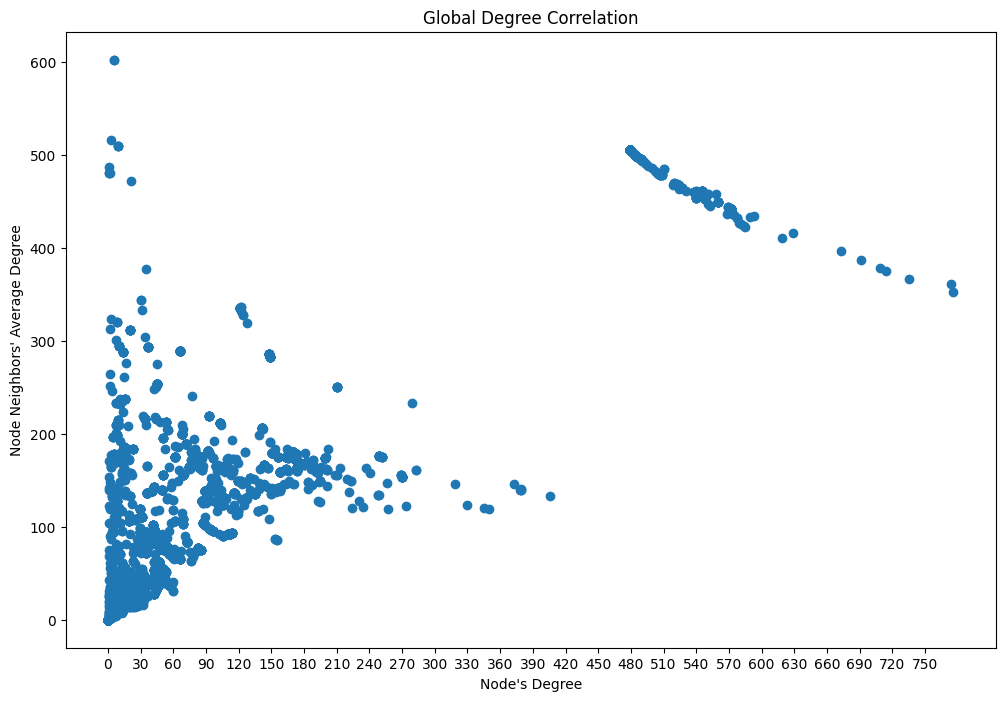

Degree correlation: 0.8314741066051596


In [13]:
# Getting the degree correlation between nodes. -- Nodes degree x Avarage neighbors degree --

# Calcula o grau dos nós e o grau médio dos vizinhos
node_degrees = dict(G.degree())
print(node_degrees)
print(max(node_degrees.values()))

avg_neighbor_degrees = {}
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    #print("Node:", node, "Neighbors:", neighbors)
    avg_neighbor_degrees[node] = np.mean([node_degrees[neighbor] for neighbor in neighbors]) if neighbors else 0
    #print("Avg neighbor degree:", avg_neighbor_degrees[node])

# Prepara os dados para o gráfico
x = list(node_degrees.values())
y = list(avg_neighbor_degrees.values())

plt.figure(figsize=(12, 8))

new_ticks = np.arange(0, max(node_degrees.values()), 30)
plt.xticks(new_ticks)

# Cria o gráfico
plt.scatter(x, y)
plt.xlabel("Node's Degree")
plt.ylabel("Node Neighbors' Average Degree")
plt.title("Global Degree Correlation")
plt.show()

degree_correlation = nx.degree_assortativity_coefficient(G)
print(f"Degree correlation: {degree_correlation}")

## First Hypothesis: Does medicines from the same regulatory categories tends to share the same active ingredients?



### Visual representation of the links between nodes.

Each category is shown by it's name and the nodes are grouped by category. The different edge's colors represent different active ingredients.

KeyboardInterrupt: 

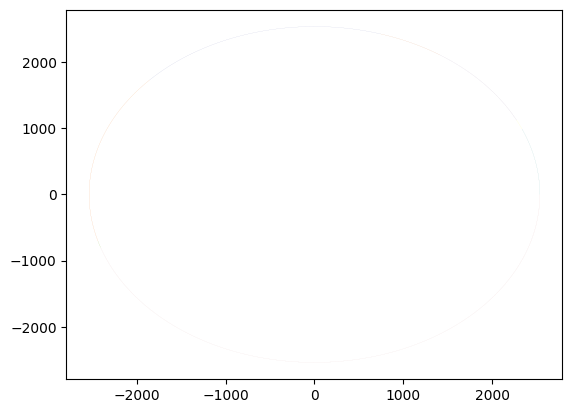

In [14]:
x = medicines['CATEGORIA_REGULATORIA'].unique()
#print(x)
y = active_filtered
#print(y)

for index, row in medicines.iterrows():  # Iterate over the cleaned DataFrame
    node_name = row['NOME_PRODUTO']  # Assuming 'Nome do Medicamento' is your node identifier
    if node_name in G:
        G.nodes[node_name]['category'] = str(row['CATEGORIA_REGULATORIA']) # Convert to string
    else:
        # Handle cases where a node in the DataFrame is not in the graph, if needed
        print(f"Warning: Node '{node_name}' from DataFrame not found in the graph.")

# Get unique categories and create mapping:
categories = [attributes.get('category') for node, attributes in G.nodes(data=True)]

# Ensure all categories are strings:
unique_categories = sorted(list(set(str(category) for category in categories)))

# Create category mapping:
category_mapping = {category: i for i, category in enumerate(unique_categories)}

ax = nv.circos(G,
               group_by="category",
               node_color_by="category",  # Use 'category' as the color attribute
               edge_color_by="color"
               )
annotate.circos_group(G, group_by="category")

# Save figure
plt.savefig("assortativity.png",
            format="png",
            dpi=400,
            bbox_inches="tight",
            transparent=True)

# Display graph

plt.show()

### Creating the mixing matrix to show the assortativity relation between columns.



In [15]:
# prompt: Use a função nx.attribute_mixing_matrix(G, 'category') para criar uma tabela 8x8 onde os nomes das colunas e linhas são as categorias definidas por medicines['CATEGORIA_REGULATORIA'].unique()

print("Degree assortativity coefficient from global graph G:", nx.degree_assortativity_coefficient(G), "\n")
print("Assortativity coefficient for the category attributes from global graph G:", nx.attribute_assortativity_coefficient(G, 'category'), "\n\n")

mixing_matrix = nx.attribute_mixing_matrix(G, 'category')

# Obtenha as categorias únicas
#print(nx.get_node_attributes(G, 'category'))
category_labels = sorted(list(set(nx.get_node_attributes(G, 'category').values())))

# Crie um DataFrame Pandas com a matriz de mistura
df_mixing_matrix = pd.DataFrame(mixing_matrix, index=category_labels, columns=category_labels)

# Imprima a tabela
#print(df_mixing_matrix)
#df_mixing_matrix.to_csv('MixingMatrix_GlobalCategories.csv')
df_mixing_matrix

Degree assortativity coefficient from global graph G: 0.8314741066051596 

Assortativity coefficient for the category attributes from global graph G: 0.17269497123831481 




,BIOLOGICO,DINAMIZADO,ESPECIFICO,FITOTERAPICO,GENERICO,NOVO,RADIOFARMACO,SIMILAR
BIOLOGICO,0.000218,0.000094,0.000004,0.000065,0.000002,0.001224,0.000185,0.000164
DINAMIZADO,0.000094,0.019689,0.004716,0.026122,0.002193,0.008680,0.066073,0.003469
ESPECIFICO,0.000004,0.004716,0.013734,0.007502,0.001788,0.002027,0.016404,0.001572
FITOTERAPICO,0.000065,0.026122,0.007502,0.038732,0.003507,0.008487,0.095142,0.004404
GENERICO,0.000002,0.002193,0.001788,0.003507,0.001671,0.000926,0.007567,0.000752
NOVO,0.001224,0.008680,0.002027,0.008487,0.000926,0.076692,0.020753,0.001803
RADIOFARMACO,0.000185,0.066073,0.016404,0.095142,0.007567,0.020753,0.246381,0.010640
SIMILAR,0.000164,0.003469,0.001572,0.004404,0.000752,0.001803,0.010640,0.010350


> From the mixing matrix it is possible to see that medicines from the same category does not tend to share the same active ingredients. Most of the elements from the main diagonal are not the highest columns' values.

### Degree assortativity coefficients for each medicine category

In [16]:
# prompt: Crie subgrafos de G Para cada categoria: 'NOVO' 'SIMILAR' 'FITOTERÁPICO' 'ESPECÍFICO' 'GENÉRICO' 'BIOLÓGICO'
#  'DINAMIZADO' 'RADIOFÁRMACO' 'PRODUTO DE T' os nós de G possuem um atributo category que definem a categoria

subgraphs = {}
for category in medicines['CATEGORIA_REGULATORIA'].unique():
  nodes_in_category = [node for node, data in G.nodes(data=True) if data.get('category') == category]
  if nodes_in_category:
    subgraphs[category] = G.subgraph(nodes_in_category)
    try:
      # Calculate assortativity coefficient, handling potential division by zero:
      assortativity_coeff = nx.degree_assortativity_coefficient(subgraphs[category])
    except (ValueError, ZeroDivisionError, RuntimeWarning) as e:
      # If error occurs, it likely means nodes with degree zero or an invalid graph structure
      print(f"Could not calculate assortativity coefficient for category '{category}': {e}")
      assortativity_coeff = float('nan')  # Assign NaN if calculation fails

    print(f"Subgraph: '{category}' is a '{subgraphs[category]}'. Local assortativity coefficient: '{assortativity_coeff}'.")

# Now you have a dictionary 'subgraphs' where keys are the categories and values are the corresponding subgraphs.
# You can access them like this:
# subgraphs['NOVO']  # For the subgraph containing nodes with category 'NOVO'
# subgraphs['SIMILAR']  # For the subgraph containing nodes with category 'SIMILAR'
# etc.

Subgraph: 'NOVO' is a 'Graph with 1312 nodes and 5148 edges'. Local assortativity coefficient: '0.8382862438186572'.
Subgraph: 'SIMILAR' is a 'Graph with 3578 nodes and 64419 edges'. Local assortativity coefficient: '0.8480137450657531'.
Subgraph: 'FITOTERAPICO' is a 'Graph with 370 nodes and 3591 edges'. Local assortativity coefficient: '0.7989043276744551'.
Subgraph: 'ESPECIFICO' is a 'Graph with 664 nodes and 20052 edges'. Local assortativity coefficient: '0.03563735068555577'.
Subgraph: 'GENERICO' is a 'Graph with 1417 nodes and 10127 edges'. Local assortativity coefficient: '0.8296470864492157'.
Subgraph: 'BIOLOGICO' is a 'Graph with 509 nodes and 2706 edges'. Local assortativity coefficient: '0.8997917575957224'.
Subgraph: 'DINAMIZADO' is a 'Graph with 73 nodes and 437 edges'. Local assortativity coefficient: '0.1398866615000812'.
Subgraph: 'RADIOFARMACO' is a 'Graph with 47 nodes and 57 edges'. Local assortativity coefficient: '1.0000000000000013'.


In [17]:

#pos = nx.circular_layout(G)
#plt.figure(figsize=(12, 12))

#nx.draw(subgraphs['NOVO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['BIOLÓGICO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['DINAMIZADO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['ESPECÍFICO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['FITOTERÁPICO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['GENÉRICO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['PRODUTO DE T'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['RADIOFÁRMACO'], pos, with_labels=False, node_size=10)
#plt.show()
#nx.draw(subgraphs['SIMILAR'], pos, with_labels=False, node_size=10)

#plt.show()

# 4. Second network - Bipartite graph with medicines and active ingredients

In [18]:
# prompt: Crie um grafo bipartido B onde um grupo vai ser dado pelos elementos do array active_filtered e o outro grupo vai ser dado por medicines['NOME_PRODUTO'].unique()

B = nx.Graph()

# Adicione os nós para os princípios ativos e os medicamentos
B.add_nodes_from(active_filtered, bipartite=2)  # Princípios ativos pertencem ao conjunto 0
B.add_nodes_from(list(set(medicines['NOME_PRODUTO'].unique())), bipartite=1)  # Medicamentos pertencem ao conjunto 1

# Adicione as arestas entre os princípios ativos e os medicamentos

for index, row in medicines.iterrows():

    nome_medicamento = row['NOME_PRODUTO']
    principios_ativos_medicamento = list(set(row['PRINCIPIO_ATIVO'].split('+'))) # Separa os princípios ativos
    print("Nome:", nome_medicamento)
    print("Ativos:", principios_ativos_medicamento)

    for principio_ativo in principios_ativos_medicamento:
        principio_ativo = principio_ativo.strip()
        print("Ativo for:", principio_ativo)
        if principio_ativo in [p.strip() for p in principios_ativos_medicamento]: # Verifica se o principio_ativo está presente

           #B.add_nodes_from(active_filtered, bipartite=0)  # Princípios ativos pertencem ao conjunto 0
           #B.add_nodes_from(medicines['NOME_PRODUTO'].unique()

           B.add_edge(principio_ativo, nome_medicamento)

A saída de streaming foi truncada nas últimas 5000 linhas.
Ativos: ['ACETILCISTEINA']
Ativo for: ACETILCISTEINA
Nome: ORFADIN
Ativos: ['NITISINONA']
Ativo for: NITISINONA
Nome: POMALYST
Ativos: ['POMALIDOMIDA']
Ativo for: POMALIDOMIDA
Nome: ibuprofeno
Ativos: ['IBUPROFENO']
Ativo for: IBUPROFENO
Nome: CEPLUVITIN
Ativos: ['ACIDO ASCORBICO']
Ativo for: ACIDO ASCORBICO
Nome: D.NOVA D3
Ativos: ['COLECALCIFEROL']
Ativo for: COLECALCIFEROL
Nome: LICITRO
Ativos: ['CITRATO DE POTASSIO MONOIDRATADO']
Ativo for: CITRATO DE POTASSIO MONOIDRATADO
Nome: CYFENOL CAF
Ativos: ['CAFEINA ANIDRA ', '  PARACETAMOL']
Ativo for: CAFEINA ANIDRA
Ativo for: PARACETAMOL
Nome: Cloridrato de memantina
Ativos: ['CLORIDRATO DE MEMANTINA']
Ativo for: CLORIDRATO DE MEMANTINA
Nome: GABANEURIN
Ativos: ['GABAPENTINA']
Ativo for: GABAPENTINA
Nome: GLICEFOR
Ativos: ['CLORIDRATO DE METFORMINA']
Ativo for: CLORIDRATO DE METFORMINA
Nome: KOKSARA
Ativos: ['DOCETAXEL TRIIDRATADO']
Ativo for: DOCETAXEL TRIIDRATADO
Nome: PAXIB
A

A saída de streaming foi truncada nas últimas 5000 linhas.
  CAPECITABINA - CORRETAL
  CAPECITABINA - Coama
  CAPECITABINA - XELODA
  CAPECITABINA - capecitabina
  CAPECITABINA - CAPEDUC
  SEVOFLURANO - ANESEVO
  SEVOFLURANO - SEV
  SEVOFLURANO - SEVOCRIS
  SEVOFLURANO - SEVOFLURANO
  SEVOFLURANO - SEVONESS
  SEVOFLURANO - Sevoflurano
  SEVOFLURANO - SEVOQ
  HEMIFUMARATO DE BISOPROLOL - BICONCOR
  HEMIFUMARATO DE BISOPROLOL - BISOPRO-GRAN
  HEMIFUMARATO DE BISOPROLOL - CONCOR
  HEMIFUMARATO DE BISOPROLOL - CONCOR ANLO
  HEMIFUMARATO DE BISOPROLOL - CONCÁRDIO
  HEMIFUMARATO DE BISOPROLOL - Coraprol
  HEMIFUMARATO DE BISOPROLOL - FUMARATO DE BISOPROLOL+ HIDROCLOROTIAZIDA
  HEMIFUMARATO DE BISOPROLOL - HEMIFUMARATO DE BISOPROLOL
  HEMIFUMARATO DE BISOPROLOL - ICCOR
  HEMIFUMARATO DE BISOPROLOL - hemifumarato de bisoprolol
  SULFATO DE NEOMICINA - ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA
  SULFATO DE NEOMICINA - ACETONIDO DE TRIANCINOLONA+SULFATO DE NEOMICINA+GRAMICIDINA+NISTATINA
  SUL

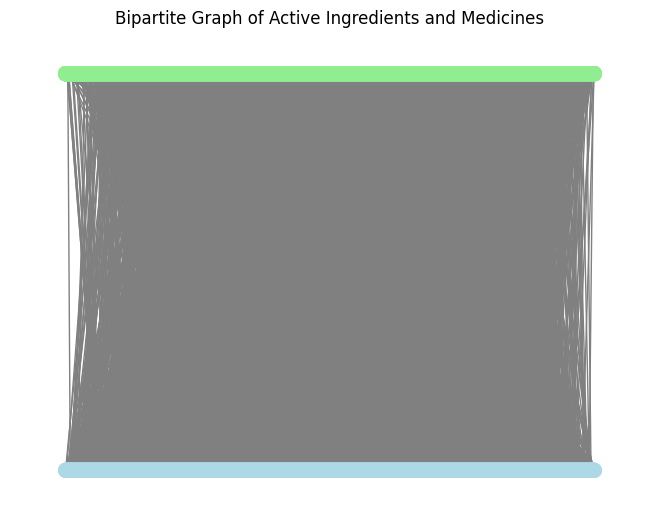

In [19]:
# Assuming 'B' is your bipartite graph and it's already created

print(B.nodes(data=True))

# Separate nodes into two sets based on their bipartite attribute
active_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 2}  # changed to get bipartite
medicine_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 1}  # changed to get bipartite


# Get nodes in bipartite set 1
nodes_set1 = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 1}

# Check for edges within set 1
edges_within_set1 = []
for u, v in B.edges():
    if u in nodes_set1 and v in nodes_set1:
        edges_within_set1.append((u, v))

# Print the results
if edges_within_set1:
    print("Edges within bipartite set 1:")
    for u, v in edges_within_set1:
        print(f"  {u} - {v}")
else:
    print("No edges found within bipartite set 1. The graph is properly bipartite.")


# Removing possible duplicates

common_elements = set(active_filtered) & set(medicines['NOME_PRODUTO'].unique())

if common_elements:
  print("Common elements found:", common_elements)
  for element in common_elements:
      if B.has_edge(element, element):
          B.remove_edge(element, element)
          print(f"Edge between '{element}' and '{element}' removed from bipartite graph B.")
      else:
          print(f"No edge found between '{element}' and '{element}' in bipartite graph B.")

else:
    print("No common elements found between active_filtered and medicines['NOME_PRODUTO'].")

# Define node positions using a bipartite layout
# Modified to receive correct arguments
pos = nx.bipartite_layout(B, nodes=active_nodes, align='horizontal')

# Draw the graph
nx.draw(B, pos, with_labels=False, node_color=['lightblue' if node in active_nodes else 'lightgreen' for node in B],
        node_size=100, font_size=8, edge_color='gray')

# Set title and show the plot
plt.title("Bipartite Graph of Active Ingredients and Medicines")
plt.show()

> Active ingredients shared by complex medicines ( with a lot of active ingredients ) tends to connect with other medicines with similar complexity?

First we have to know what is the average degree from the nodes in medicines' partition, so we can chose a base degree value to do our analysis.
Calculating the maximum and average degree we get:
> Maximum degree in partition 1: 151

> Average degree in partition 1: 2.004516938519448

Maximum degree in partition 1: 151
Average degree in partition 1: 2.004516938519448
Nodes in subgraph: {'DIFOSFATO DE CLOROQUINA', 'PEMETREXEDE DISSODICO HEPTAIDRATADO', 'LUMEFANTRINA', 'SULFATO DE ABACAVIR', 'TRIMETOPRIMA', 'BASILIXIMABE', 'RALTEGRAVIR POTASSICO', 'DECANOATO DE ZUCLOPENTIXOL', 'POLISSACARIDEO CAPSULAR DE STREPTOCOCCUS PNEUMONIAE SOROTIPO 23F', 'DIMENIDRINATO', 'CONIUM MACULATUM', 'DEXTROSE ANIDRA', 'TEUCRIUM SCORODONIA', 'ANTIGENOS BACTERIANOS SOB A FORMA DE LISADOS', 'ALFALUTROPINA', 'DELAFLOXACINO MEGLUMINA', 'TRIOXIDO DE ARSENIO', 'TIOCONAZOL', 'CICLESONIDA', 'ACETATO DE RACEALFATOCOFEROL', 'NORELGESTROMINA', 'CANFORA', 'POLIOVIRUS TIPO 3', 'SULBACTAM PIVOXILA', 'SUCCINATO DE DOXILAMINA', 'SULFATO DE PSEUDOEFEDRINA', 'STRYPHNODENDRON ADSTRINGENS (MART.) COVILLE', 'IBANDRONATO DE SODIO MONOIDRATADO', 'CLORIDRATO DE ALFENTANILA MONOIDRATADA', 'PIRIMETAMINA', 'ZOPICLONA', 'ACETATO DE HIDROXOCOBALAMINA', 'VESICULAS DE MEMBRANA EXTERNA (OMV) DE NEISSERIA MENINGITIDIS GR

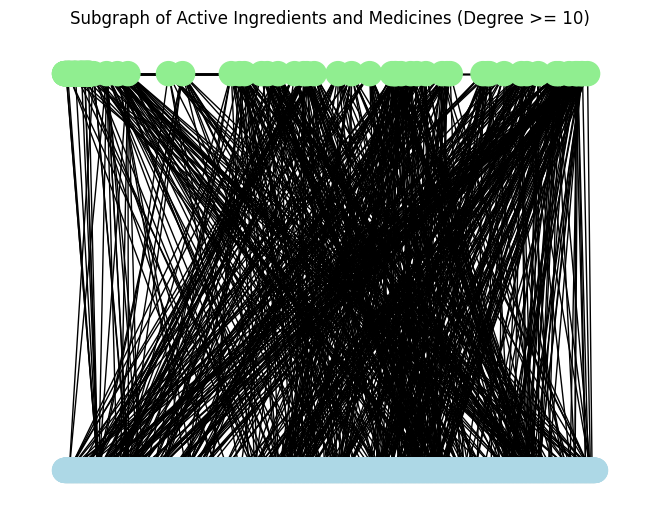

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Get nodes in bipartite set 1
nodes_set1 = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 1}

# Calculate degree for nodes in partition 1 (medicine nodes)
degrees_set1 = {node: B.degree(node) for node in nodes_set1}

# Get maximum degree in partition 1
max_degree_set1 = max(degrees_set1.values()) if degrees_set1 else 0

# Calculate the average degree in partition 1
avg_degree_set1 = np.mean(list(degrees_set1.values())) if degrees_set1 else 0

print(f"Maximum degree in partition 1: {max_degree_set1}")
print(f"Average degree in partition 1: {avg_degree_set1}")

# Subgraph created will be all the active ingredients (partition 2)
# and the medicine nodes (partition 1) with 10 or more links

# Start with active ingredient nodes (bipartite set 2)
nodes_sb = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 2}

# Add medicine nodes (bipartite set 1) with degree >= 10
for node, degree in degrees_set1.items():
  if degree >= 10:
    nodes_sb.add(node)

print("Nodes in subgraph:", nodes_sb)

# Now, nodes_sb contains both active ingredients and medicines with degree >= 10
# You can create the subgraph using:

B_subgraph = B.subgraph(nodes_sb)

print(B_subgraph.nodes(data=True))

pos_subgraph = nx.bipartite_layout(B_subgraph, nodes=[node for node, data in B_subgraph.nodes(data=True) if data.get('bipartite') == 2], align='horizontal')

nx.draw(B_subgraph, pos, with_labels=False,  node_color=['lightblue' if B.nodes[node].get('bipartite') == 2 else 'lightgreen' for node in B_subgraph])

plt.title("Subgraph of Active Ingredients and Medicines (Degree >= 10)")
plt.show()

### Calculating the assortativity



```
print(B_subgraph.number_of_nodes()) # 2212 nodes
print(B_subgraph.number_of_edges()) # 712 edges


assortativity_coeff_b_subgraph = nx.degree_assortativity_coefficient(B_subgraph)
# -0.3910127771101286
 ```

With a negative degree related assortativity coefficient we can assume the for this selected group of nodes, they tend to be dissortative. They do not tend to make connecting with one another.




In [21]:
# prompt: Calculate the assortativity from graph B_subgraph

print(B_subgraph.number_of_nodes())
print(B_subgraph.number_of_edges())

assortativity_coeff_b_subgraph = nx.degree_assortativity_coefficient(B_subgraph)
print(f"Assortativity coefficient for B_subgraph: {assortativity_coeff_b_subgraph}")

2212
712
Assortativity coefficient for B_subgraph: -0.3910127771101286
